In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from collections import Counter
from wordcloud import WordCloud
import sqlite3
from sqlalchemy import create_engine

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [10]:
#!pip install wordcloud

In [37]:
file_path = "/Users/ashishchaudhary/Desktop/Nextleap_/project/merged_jobs_wide_tableau.csv"

In [41]:
# ========================================
# 1. DATA LOADING & PREPROCESSING
# ========================================

def load_and_clean_data(file_path):
    """Load and clean the job market dataset"""
    print("🔄 Loading dataset...")
    
    # Load data
    df = pd.read_csv(file_path)
    
    print(f"✅ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"📊 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Basic info
    print("\n📋 DATASET INFO:")
    print("="*50)
    print(df.info())
    
    print("\n📈 BASIC STATISTICS:")
    print("="*50)
    print(df.describe(include='all'))
    
    # Check for missing values
    print("\n🔍 MISSING VALUES:")
    print("="*50)
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Percentage': missing_percent
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    return df

In [43]:
load_and_clean_data('/Users/ashishchaudhary/Desktop/Nextleap_/project/merged_jobs_wide_tableau.csv')

🔄 Loading dataset...
✅ Dataset loaded: 681062 rows, 9 columns
📊 Memory usage: 343.50 MB

📋 DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681062 entries, 0 to 681061
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Title        681062 non-null  object
 1   Company      681062 non-null  object
 2   Location     681062 non-null  object
 3   Type         681062 non-null  object
 4   Level        681062 non-null  object
 5   Posted_On    678510 non-null  object
 6   domains      679488 non-null  object
 7   skills       679622 non-null  object
 8   soft_skills  671606 non-null  object
dtypes: object(9)
memory usage: 46.8+ MB
None

📈 BASIC STATISTICS:
                  Title     Company   Location       Type        Level  \
count            681062      681062     681062     681062       681062   
unique              194        2907        138          5            3   
top     product manager  Mastercar

,Title,Company,Location,Type,Level,Posted_On,domains,skills,soft_skills
0,business analyst,Time Hack Consulting,Bengaluru,Full-time,Entry level,2025-09-12,finance,r,communication
1,business analyst,Time Hack Consulting,Bengaluru,Full-time,Entry level,2025-09-12,ar,r,communication
2,business analyst,Time Hack Consulting,Bengaluru,Full-time,Entry level,2025-09-12,support,r,communication
3,business analyst,Time Hack Consulting,Bengaluru,Full-time,Entry level,2025-09-12,risk,r,communication
4,business analyst,Knowledgist ®,India,Full-time,Entry level,2025-09-12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
681057,product designer,Karnival,Gurugram,Full-time,Entry level,2025-05-31,ar,sketch,adaptability
681058,product designer,Karnival,Gurugram,Full-time,Entry level,2025-05-31,ar,illustrator,time management
681059,product designer,Karnival,Gurugram,Full-time,Entry level,2025-05-31,ar,illustrator,adaptability
681060,product designer,Karnival,Gurugram,Full-time,Entry level,2025-05-31,ar,r,time management


In [49]:
df = pd.read_csv("/Users/ashishchaudhary/Desktop/Nextleap_/project/merged_jobs_wide_tableau.csv")

In [51]:
def prepare_data_for_analysis(df):
    """Clean and structure data for analysis"""
    print("\n🔧 PREPARING DATA FOR ANALYSIS...")
    
    # Convert Posted_On to datetime
    if 'Posted_On' in df.columns:
        df['Posted_On'] = pd.to_datetime(df['Posted_On'], format='%d/%m/%y', errors='coerce')
    
    # Clean and standardize columns
    df['Title'] = df['Title'].str.title()
    df['Company'] = df['Company'].str.strip()
    df['Location'] = df['Location'].str.strip()
    
    # Create skill and soft skill lists
    df['skills_list'] = df['skills'].fillna('').astype(str)
    df['soft_skills_list'] = df['soft_skills'].fillna('').astype(str)
    df['domains_list'] = df['domains'].fillna('').astype(str)
    
    print("✅ Data preparation completed!")
    return df

prepare_data_for_analysis(df)


🔧 PREPARING DATA FOR ANALYSIS...
✅ Data preparation completed!


,Title,Company,Location,Type,Level,Posted_On,domains,skills,soft_skills,skills_list,soft_skills_list,domains_list
0,Business Analyst,Time Hack Consulting,Bengaluru,Full-time,Entry level,NaT,finance,r,communication,r,communication,finance
1,Business Analyst,Time Hack Consulting,Bengaluru,Full-time,Entry level,NaT,ar,r,communication,r,communication,ar
2,Business Analyst,Time Hack Consulting,Bengaluru,Full-time,Entry level,NaT,support,r,communication,r,communication,support
3,Business Analyst,Time Hack Consulting,Bengaluru,Full-time,Entry level,NaT,risk,r,communication,r,communication,risk
4,Business Analyst,Knowledgist ®,India,Full-time,Entry level,NaT,NaN,NaN,NaN,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
681057,Product Designer,Karnival,Gurugram,Full-time,Entry level,NaT,ar,sketch,adaptability,sketch,adaptability,ar
681058,Product Designer,Karnival,Gurugram,Full-time,Entry level,NaT,ar,illustrator,time management,illustrator,time management,ar
681059,Product Designer,Karnival,Gurugram,Full-time,Entry level,NaT,ar,illustrator,adaptability,illustrator,adaptability,ar
681060,Product Designer,Karnival,Gurugram,Full-time,Entry level,NaT,ar,r,time management,r,time management,ar


In [16]:
# ========================================
# 2. EXPLORATORY DATA ANALYSIS FUNCTIONS
# ========================================


In [53]:
def job_market_overview(df):
    """Generate comprehensive job market overview"""
    print("\n📊 JOB MARKET OVERVIEW")
    print("="*60)
    
    # Basic metrics
    total_jobs = df['Title'].nunique() if len(df['Title'].unique()) > 1 else len(df)
    unique_companies = df['Company'].nunique()
    unique_locations = df['Location'].nunique()
    unique_skills = len([skill for skills in df['skills'].dropna() for skill in str(skills).split(',')])
    
    overview_metrics = {
        'Total Job Postings': len(df),
        'Unique Job Titles': total_jobs,
        'Companies Hiring': unique_companies,
        'Locations': unique_locations,
        'Date Range': f"{df['Posted_On'].min()} to {df['Posted_On'].max()}" if 'Posted_On' in df.columns else "N/A"
    }
    
    for metric, value in overview_metrics.items():
        print(f"📈 {metric}: {value}")
    
    return overview_metrics

job_market_overview(df)


📊 JOB MARKET OVERVIEW
📈 Total Job Postings: 681062
📈 Unique Job Titles: 194
📈 Companies Hiring: 2907
📈 Locations: 138
📈 Date Range: NaT to NaT


{'Total Job Postings': 681062,
 'Unique Job Titles': 194,
 'Companies Hiring': 2907,
 'Locations': 138,
 'Date Range': 'NaT to NaT'}


💼 JOB TITLES ANALYSIS
🏆 TOP 10 JOB TITLES:
 1. Product Manager: 193755 jobs (28.4%)
 2. Software Engineer: 112606 jobs (16.5%)
 3. Product Designer: 56831 jobs (8.3%)
 4. Frontend Developer: 43295 jobs (6.4%)
 5. Data Analyst: 39865 jobs (5.9%)
 6. Business Analyst: 35712 jobs (5.2%)
 7. Backend Developer: 25950 jobs (3.8%)
 8. Full Stack Developer: 16707 jobs (2.5%)
 9. Software Engineer  Frontend/ Ui: 13608 jobs (2.0%)
10. Software Engineer  Java: 9900 jobs (1.5%)


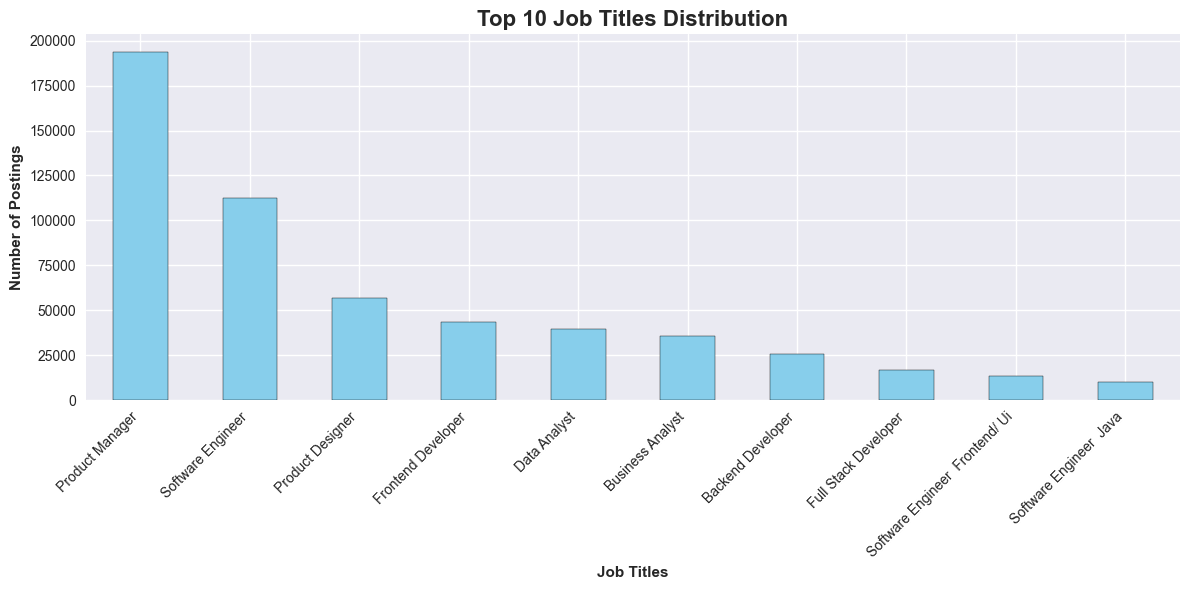

Title
Product Manager                                      193755
Software Engineer                                    112606
Product Designer                                      56831
Frontend Developer                                    43295
Data Analyst                                          39865
                                                      ...  
Ui/Ux Experience Designer                                 2
Staff Engineer Frontend Developer Bem Methodology         2
Associate Product Manager Credit Cards                    2
Market Analyst                                            2
Python Backend Developer Gen Ai Gurgaon                   2
Name: count, Length: 194, dtype: int64

In [55]:
def analyze_job_titles(df):
    """Analyze job title distribution"""
    print("\n💼 JOB TITLES ANALYSIS")
    print("="*60)
    
    # Job title frequency
    job_counts = df['Title'].value_counts()
    
    print("🏆 TOP 10 JOB TITLES:")
    for i, (title, count) in enumerate(job_counts.head(10).items(), 1):
        percentage = (count / len(df)) * 100
        print(f"{i:2d}. {title}: {count} jobs ({percentage:.1f}%)")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    job_counts.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Top 10 Job Titles Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Job Titles', fontweight='bold')
    plt.ylabel('Number of Postings', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return job_counts

analyze_job_titles(df)


🏢 COMPANIES ANALYSIS
🏆 TOP 15 COMPANIES BY JOB POSTINGS:
 1. Mastercard: 22383 jobs (3.3%)
 2. Precisely: 14443 jobs (2.1%)
 3. Walmart Global Tech India: 10772 jobs (1.6%)
 4. Zeta: 10135 jobs (1.5%)
 5. Whatfix: 9475 jobs (1.4%)
 6. Lowe's India: 8176 jobs (1.2%)
 7. PayU: 7092 jobs (1.0%)
 8. Mindtickle: 6772 jobs (1.0%)
 9. NetApp: 5651 jobs (0.8%)
10. Boo: 5056 jobs (0.7%)
11. FICO: 4752 jobs (0.7%)
12. Innovapptive Inc: 4305 jobs (0.6%)
13. Darwix AI: 4104 jobs (0.6%)
14. Exxat: 3082 jobs (0.5%)
15. mypatta: 3024 jobs (0.4%)

📊 TOP 10 COMPANIES DETAILED ANALYSIS:
                           Total_Posts  Unique_Roles  Locations
Company                                                        
Mastercard                       22383             3          3
Precisely                        14443             3          1
Walmart Global Tech India        10772             2          2
Zeta                             10135             7          3
Whatfix                           9475 

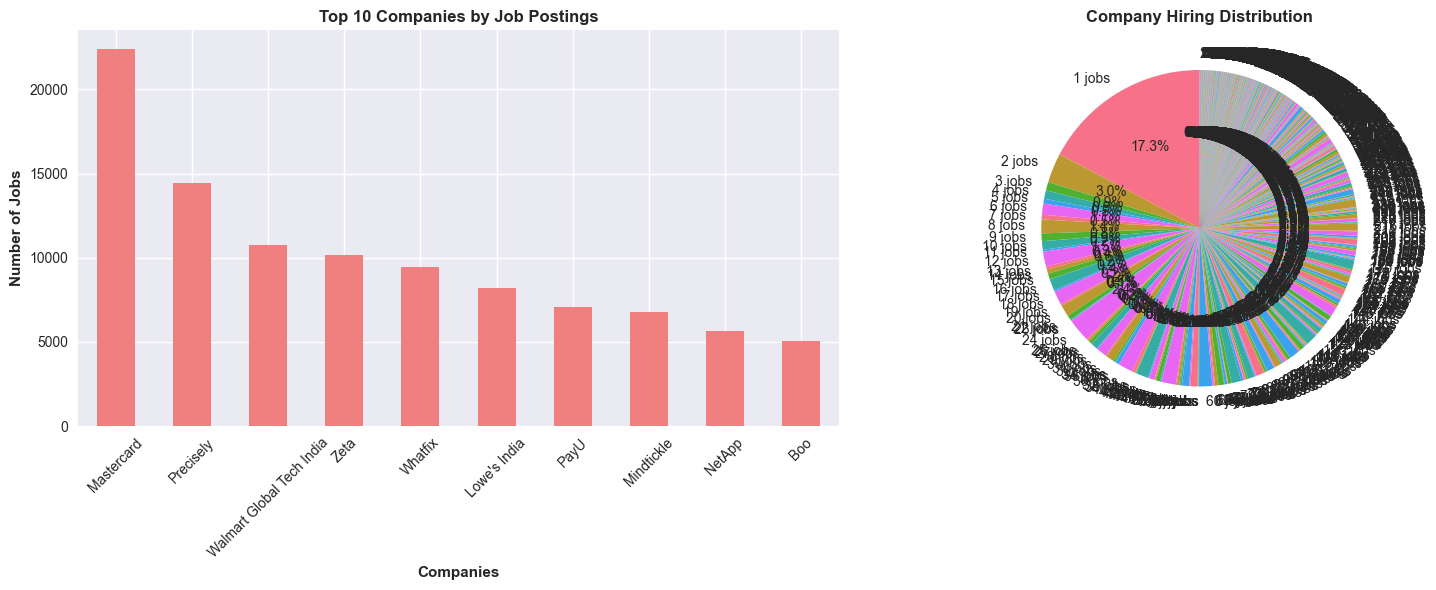

(Company
 Mastercard                   22383
 Precisely                    14443
 Walmart Global Tech India    10772
 Zeta                         10135
 Whatfix                       9475
                              ...  
 Refactor Academy                 1
 Delta Exchange                   1
 Vettam AI                        1
 Focalworks                       1
 Paysecure                        1
 Name: count, Length: 2907, dtype: int64,
                            Total_Posts  Unique_Roles  Locations
 Company                                                        
 Mastercard                       22383             3          3
 Precisely                        14443             3          1
 Walmart Global Tech India        10772             2          2
 Zeta                             10135             7          3
 Whatfix                           9475             5          2
 ...                                ...           ...        ...
 Synegrow                        

In [57]:

def analyze_companies(df):
    """Analyze company hiring patterns"""
    print("\n🏢 COMPANIES ANALYSIS")
    print("="*60)
    
    # Company hiring frequency
    company_counts = df['Company'].value_counts()
    
    print("🏆 TOP 15 COMPANIES BY JOB POSTINGS:")
    for i, (company, count) in enumerate(company_counts.head(15).items(), 1):
        percentage = (count / len(df)) * 100
        print(f"{i:2d}. {company}: {count} jobs ({percentage:.1f}%)")
    
    # Company size analysis
    company_job_distribution = df.groupby('Company').agg({
        'Title': ['count', 'nunique'],
        'Location': 'nunique'
    }).round(2)
    
    company_job_distribution.columns = ['Total_Posts', 'Unique_Roles', 'Locations']
    company_job_distribution = company_job_distribution.sort_values('Total_Posts', ascending=False)
    
    print(f"\n📊 TOP 10 COMPANIES DETAILED ANALYSIS:")
    print(company_job_distribution.head(10))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top companies bar plot
    company_counts.head(10).plot(kind='bar', ax=ax1, color='lightcoral')
    ax1.set_title('Top 10 Companies by Job Postings', fontweight='bold')
    ax1.set_xlabel('Companies', fontweight='bold')
    ax1.set_ylabel('Number of Jobs', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    # Company hiring distribution
    hiring_ranges = company_counts.value_counts().sort_index()
    ax2.pie(hiring_ranges.values, labels=[f'{i} jobs' for i in hiring_ranges.index], 
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Company Hiring Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return company_counts, company_job_distribution


analyze_companies(df)


🌍 LOCATION ANALYSIS
🏆 TOP 15 LOCATIONS BY JOB AVAILABILITY:
 1. Bengaluru: 261700 jobs (38.4%)
 2. India: 85415 jobs (12.5%)
 3. Gurugram: 61319 jobs (9.0%)
 4. Pune: 58260 jobs (8.6%)
 5. Hyderabad: 47381 jobs (7.0%)
 6. Mumbai: 27051 jobs (4.0%)
 7. Chennai: 22312 jobs (3.3%)
 8. Noida: 21824 jobs (3.2%)
 9. Gurgaon: 13244 jobs (1.9%)
10. New Delhi: 7506 jobs (1.1%)
11. Vadodara: 6738 jobs (1.0%)
12. Mumbai Metropolitan Region: 5747 jobs (0.8%)
13. Jaipur: 4870 jobs (0.7%)
14. Ahmedabad: 4815 jobs (0.7%)
15. Bangalore Urban: 4632 jobs (0.7%)

📊 TOP 10 LOCATION MARKET ANALYSIS:
                            Companies  Job_Types  Total_Jobs
Location                                                    
AE                                  1          1           0
Namakkal                            2          2           0
Mountain View                       1          1           0
Mumbai                            183         41           0
Mumbai Metropolitan Region         64         1

<Figure size 1400x800 with 0 Axes>

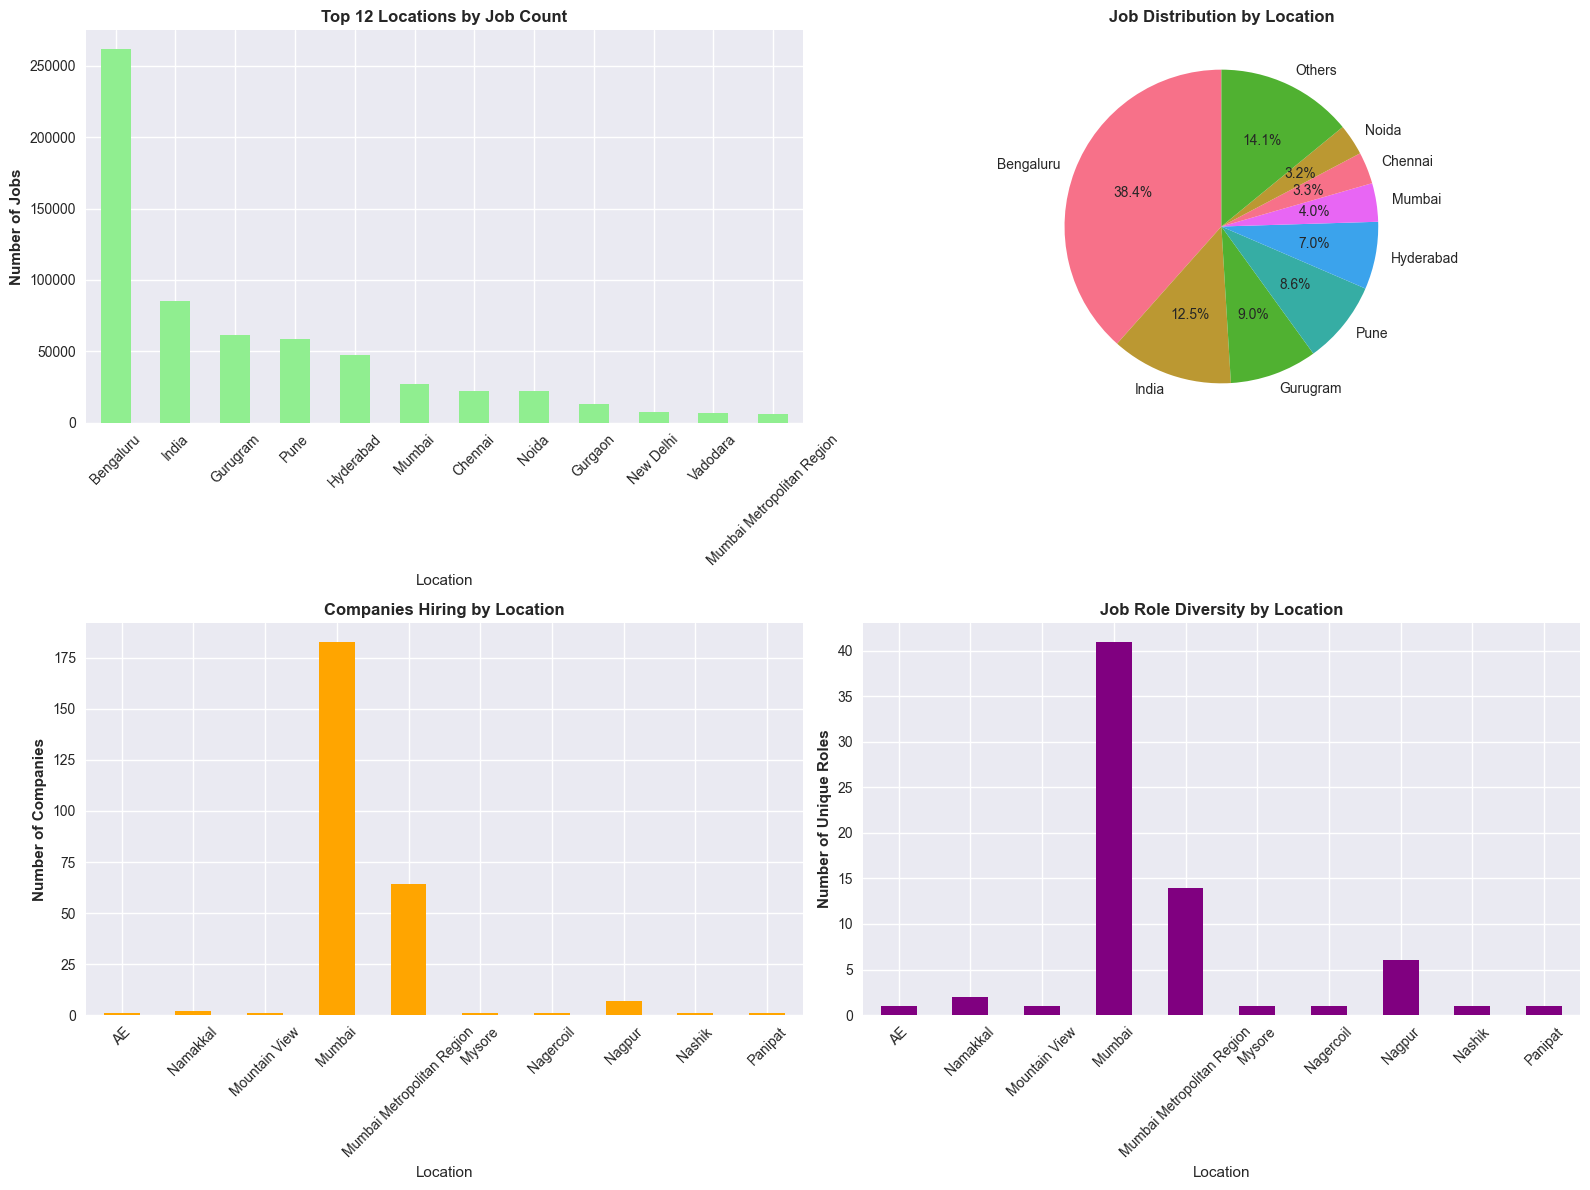

(Location
 Bengaluru    261700
 India         85415
 Gurugram      61319
 Pune          58260
 Hyderabad     47381
               ...  
 Jamnagar          1
 Dwarka            1
 Gadag             1
 Shillong          1
 AE                1
 Name: count, Length: 138, dtype: int64,
                             Companies  Job_Types  Total_Jobs
 Location                                                    
 AE                                  1          1           0
 Namakkal                            2          2           0
 Mountain View                       1          1           0
 Mumbai                            183         41           0
 Mumbai Metropolitan Region         64         14           0
 ...                               ...        ...         ...
 Goa Velha                           1          1           0
 Ghaziabad                           1          1           0
 Gautam Buddha Nagar                 4          5           0
 Gandhinagar                        

In [59]:

def analyze_locations(df):
    """Analyze job location distribution"""
    print("\n🌍 LOCATION ANALYSIS")
    print("="*60)
    
    # Location frequency
    location_counts = df['Location'].value_counts()
    
    print("🏆 TOP 15 LOCATIONS BY JOB AVAILABILITY:")
    for i, (location, count) in enumerate(location_counts.head(15).items(), 1):
        percentage = (count / len(df)) * 100
        print(f"{i:2d}. {location}: {count} jobs ({percentage:.1f}%)")
    
    # Location market analysis
    location_analysis = df.groupby('Location').agg({
        'Company': 'nunique',
        'Title': 'nunique',
        'Posted_On': 'count'
    }).round(2)
    location_analysis.columns = ['Companies', 'Job_Types', 'Total_Jobs']
    location_analysis = location_analysis.sort_values('Total_Jobs', ascending=False)
    
    print(f"\n📊 TOP 10 LOCATION MARKET ANALYSIS:")
    print(location_analysis.head(10))
    
    # Visualization
    plt.figure(figsize=(14, 8))
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Location distribution bar plot
    location_counts.head(12).plot(kind='bar', ax=axes[0,0], color='lightgreen')
    axes[0,0].set_title('Top 12 Locations by Job Count', fontweight='bold')
    axes[0,0].set_ylabel('Number of Jobs', fontweight='bold')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Location pie chart
    top_locations = location_counts.head(8)
    others = location_counts[8:].sum()
    if others > 0:
        top_locations['Others'] = others
    
    axes[0,1].pie(top_locations.values, labels=top_locations.index, autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Job Distribution by Location', fontweight='bold')
    
    # Companies per location
    location_analysis.head(10)['Companies'].plot(kind='bar', ax=axes[1,0], color='orange')
    axes[1,0].set_title('Companies Hiring by Location', fontweight='bold')
    axes[1,0].set_ylabel('Number of Companies', fontweight='bold')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Job diversity per location
    location_analysis.head(10)['Job_Types'].plot(kind='bar', ax=axes[1,1], color='purple')
    axes[1,1].set_title('Job Role Diversity by Location', fontweight='bold')
    axes[1,1].set_ylabel('Number of Unique Roles', fontweight='bold')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return location_counts, location_analysis


analyze_locations(df)


🛠️ SKILLS ANALYSIS
🏆 TOP 20 TECHNICAL SKILLS IN DEMAND:
 1. R: 112196 (16.5%)
 2. Go: 93664 (13.8%)
 3. Git: 40323 (5.9%)
 4. Less: 31837 (4.7%)
 5. Sql: 30817 (4.5%)
 6. Java: 25999 (3.8%)
 7. Scala: 24825 (3.6%)
 8. Rust: 18560 (2.7%)
 9. Python: 17960 (2.6%)
10. Javascript: 16490 (2.4%)
11. React: 15208 (2.2%)
12. Html: 13615 (2.0%)
13. Css: 13394 (2.0%)
14. Jira: 12931 (1.9%)
15. Figma: 11691 (1.7%)
16. Express: 10575 (1.6%)
17. Azure: 8382 (1.2%)
18. Adobe: 8380 (1.2%)
19. Tableau: 8204 (1.2%)
20. Ios: 7534 (1.1%)


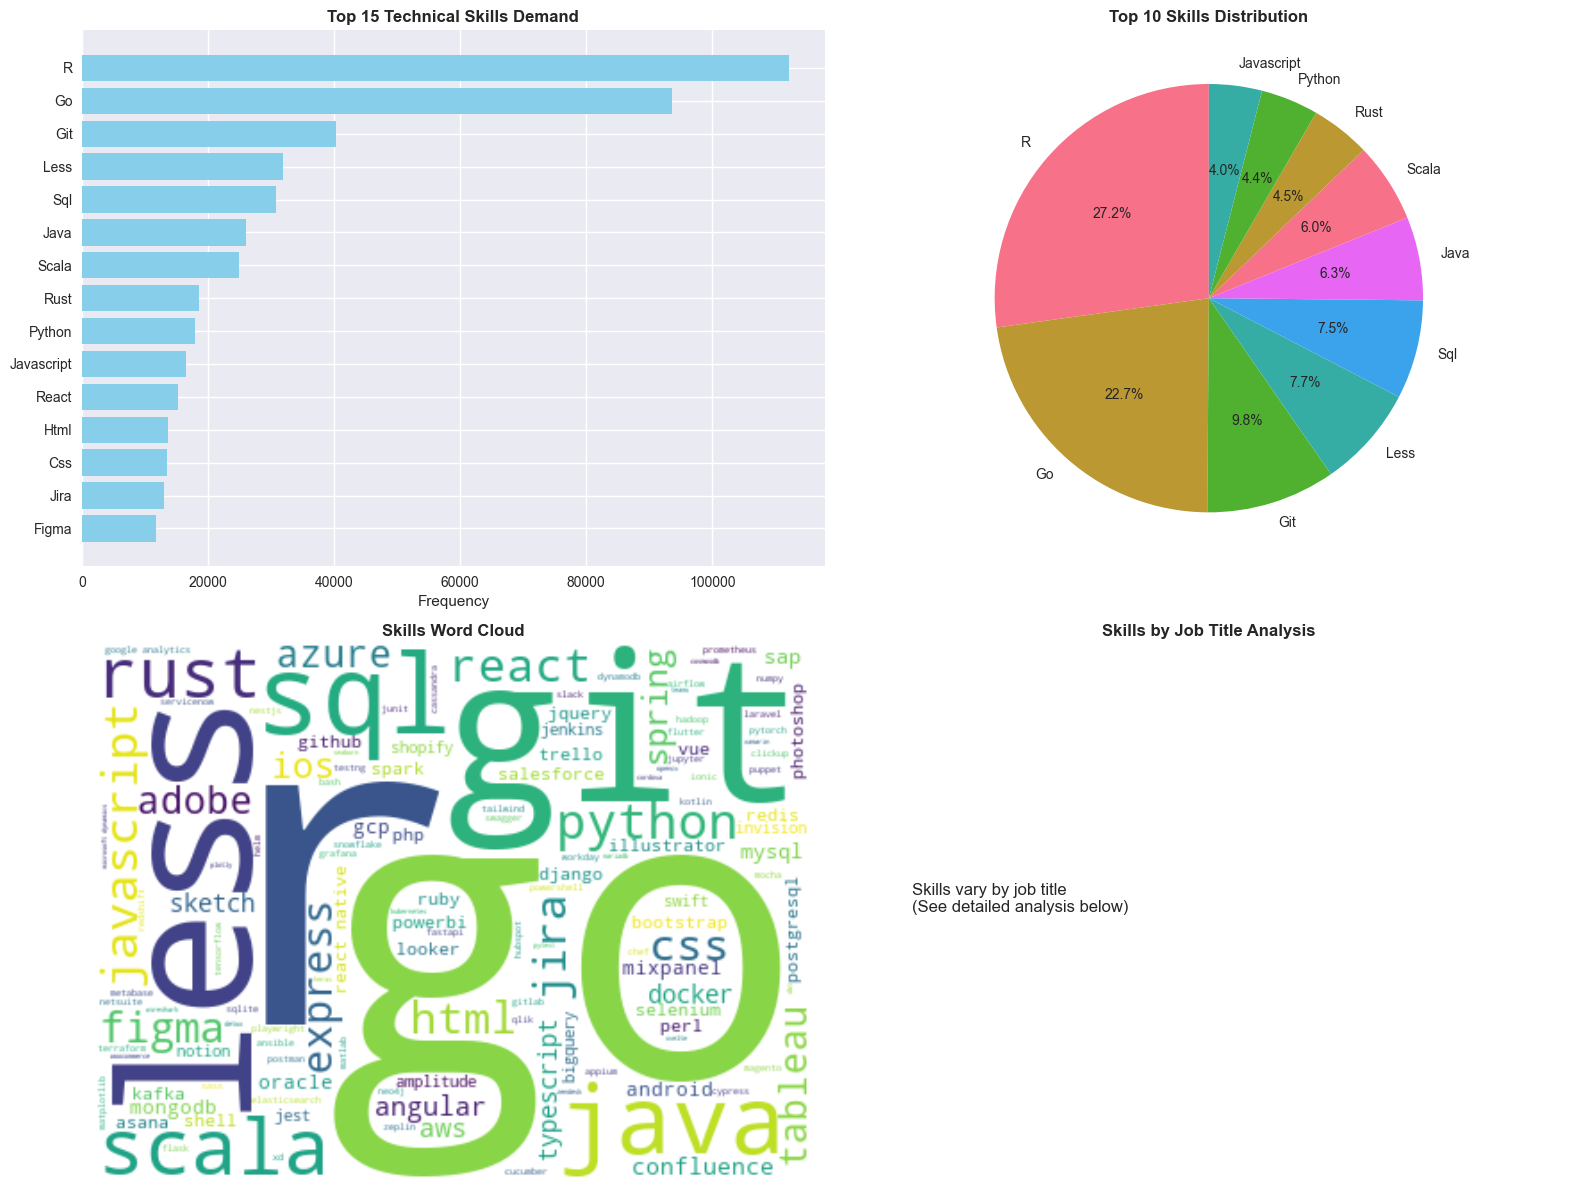

,Skill,Frequency,Percentage
0,r,112196,16.51
1,go,93664,13.78
2,git,40323,5.93
3,less,31837,4.68
4,sql,30817,4.53
...,...,...,...
135,woocommerce,15,0.00
136,cordova,12,0.00
137,spacy,6,0.00
138,nltk,6,0.00


In [61]:
def analyze_skills(df):
    """Comprehensive skills analysis"""
    print("\n🛠️ SKILLS ANALYSIS")
    print("="*60)
    
    # Extract all skills
    all_skills = []
    for skills in df['skills'].dropna():
        if pd.notna(skills):
            all_skills.extend([skill.strip().lower() for skill in str(skills).split(',')])
    
    skills_counter = Counter(all_skills)
    skills_df = pd.DataFrame(skills_counter.most_common(), columns=['Skill', 'Frequency'])
    skills_df['Percentage'] = (skills_df['Frequency'] / len(all_skills) * 100).round(2)
    
    print("🏆 TOP 20 TECHNICAL SKILLS IN DEMAND:")
    for i, row in skills_df.head(20).iterrows():
        print(f"{i+1:2d}. {row['Skill'].title()}: {row['Frequency']} ({row['Percentage']:.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top skills bar plot
    top_skills = skills_df.head(15)
    axes[0,0].barh(range(len(top_skills)), top_skills['Frequency'], color='skyblue')
    axes[0,0].set_yticks(range(len(top_skills)))
    axes[0,0].set_yticklabels(top_skills['Skill'].str.title())
    axes[0,0].set_xlabel('Frequency')
    axes[0,0].set_title('Top 15 Technical Skills Demand', fontweight='bold')
    axes[0,0].invert_yaxis()
    
    # Skills pie chart
    top_skills_pie = skills_df.head(10)
    axes[0,1].pie(top_skills_pie['Frequency'], labels=top_skills_pie['Skill'].str.title(), 
                  autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Top 10 Skills Distribution', fontweight='bold')
    
    # Skills wordcloud
    if skills_counter:
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(skills_counter)
        axes[1,0].imshow(wordcloud, interpolation='bilinear')
        axes[1,0].axis('off')
        axes[1,0].set_title('Skills Word Cloud', fontweight='bold')
    
    # Skills by job title
    if len(df['Title'].unique()) > 1:
        job_skills = df.groupby('Title')['skills'].apply(lambda x: ', '.join(x.dropna())).reset_index()
        axes[1,1].text(0.1, 0.5, "Skills vary by job title\n(See detailed analysis below)", 
                       fontsize=12, transform=axes[1,1].transAxes)
        axes[1,1].set_title('Skills by Job Title Analysis', fontweight='bold')
        axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return skills_df

analyze_skills(df)


🤝 SOFT SKILLS ANALYSIS
🏆 TOP 15 SOFT SKILLS IN DEMAND:
 1. Communication: 88176 (13.1%)
 2. Agile: 51806 (7.7%)
 3. Collaboration: 46236 (6.9%)
 4. Organization: 44488 (6.6%)
 5. Research: 42823 (6.4%)
 6. Innovation: 41349 (6.2%)
 7. Ownership: 25540 (3.8%)
 8. Lean: 24632 (3.7%)
 9. Initiative: 21632 (3.2%)
10. Efficiency: 21364 (3.2%)
11. Leadership: 19490 (2.9%)
12. Proactive: 16192 (2.4%)
13. Verbal Communication: 13043 (1.9%)
14. Presentation: 13026 (1.9%)
15. Influence: 12211 (1.8%)


<Figure size 1400x800 with 0 Axes>

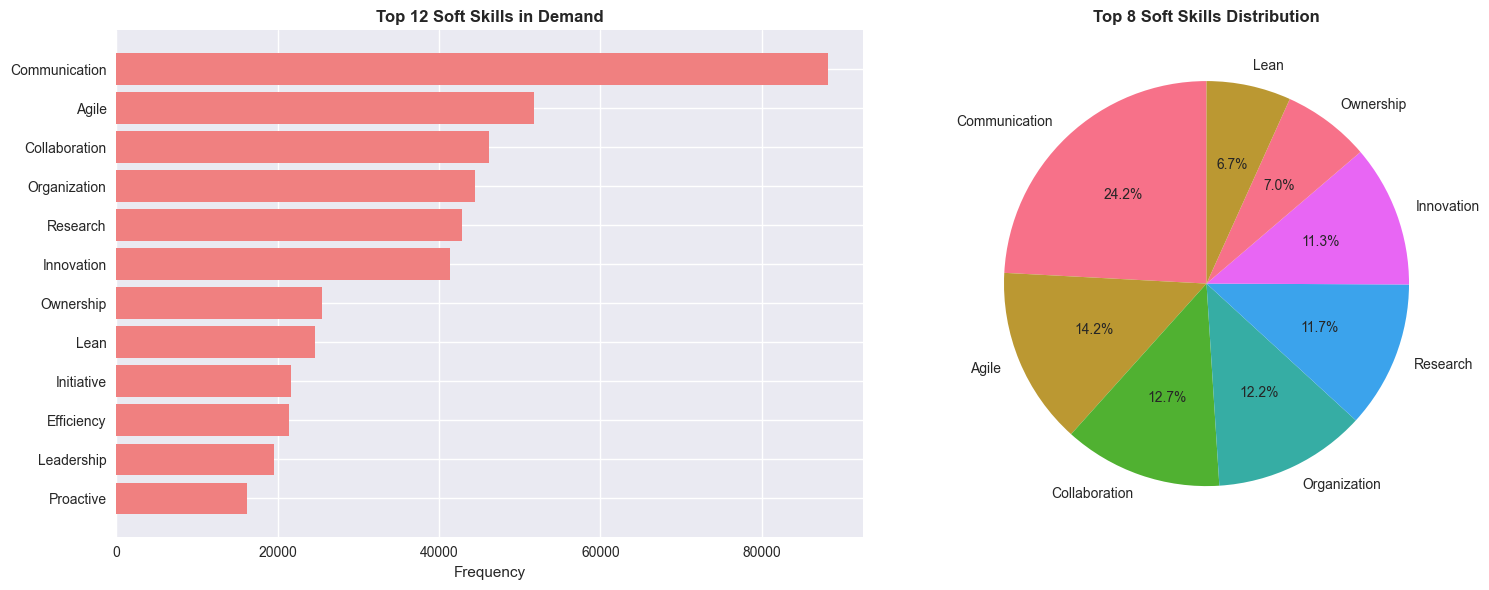

,Soft_Skill,Frequency,Percentage
0,communication,88176,13.13
1,agile,51806,7.71
2,collaboration,46236,6.88
3,organization,44488,6.62
4,research,42823,6.38
...,...,...,...
73,delegation,53,0.01
74,client management,48,0.01
75,market understanding,38,0.01
76,emotional intelligence,36,0.01


In [63]:
def analyze_soft_skills(df):
    """Analyze soft skills requirements"""
    print("\n🤝 SOFT SKILLS ANALYSIS")
    print("="*60)
    
    # Extract all soft skills
    all_soft_skills = []
    for soft_skills in df['soft_skills'].dropna():
        if pd.notna(soft_skills):
            all_soft_skills.extend([skill.strip().lower() for skill in str(soft_skills).split(',')])
    
    soft_skills_counter = Counter(all_soft_skills)
    soft_skills_df = pd.DataFrame(soft_skills_counter.most_common(), columns=['Soft_Skill', 'Frequency'])
    soft_skills_df['Percentage'] = (soft_skills_df['Frequency'] / len(all_soft_skills) * 100).round(2)
    
    print("🏆 TOP 15 SOFT SKILLS IN DEMAND:")
    for i, row in soft_skills_df.head(15).iterrows():
        print(f"{i+1:2d}. {row['Soft_Skill'].title()}: {row['Frequency']} ({row['Percentage']:.1f}%)")
    
    # Visualization
    plt.figure(figsize=(14, 8))
    
    # Create subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Soft skills bar plot
    top_soft_skills = soft_skills_df.head(12)
    ax1.barh(range(len(top_soft_skills)), top_soft_skills['Frequency'], color='lightcoral')
    ax1.set_yticks(range(len(top_soft_skills)))
    ax1.set_yticklabels(top_soft_skills['Soft_Skill'].str.title())
    ax1.set_xlabel('Frequency')
    ax1.set_title('Top 12 Soft Skills in Demand', fontweight='bold')
    ax1.invert_yaxis()
    
    # Soft skills distribution
    ax2.pie(soft_skills_df.head(8)['Frequency'], labels=soft_skills_df.head(8)['Soft_Skill'].str.title(),
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Top 8 Soft Skills Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return soft_skills_df

analyze_soft_skills(df)


📊 JOB LEVEL ANALYSIS
🎯 JOB LEVELS DISTRIBUTION:
• Entry level: 559037 jobs (82.1%)
• Mid-Senior level: 119182 jobs (17.5%)
• Director: 2843 jobs (0.4%)


<Figure size 1200x500 with 0 Axes>

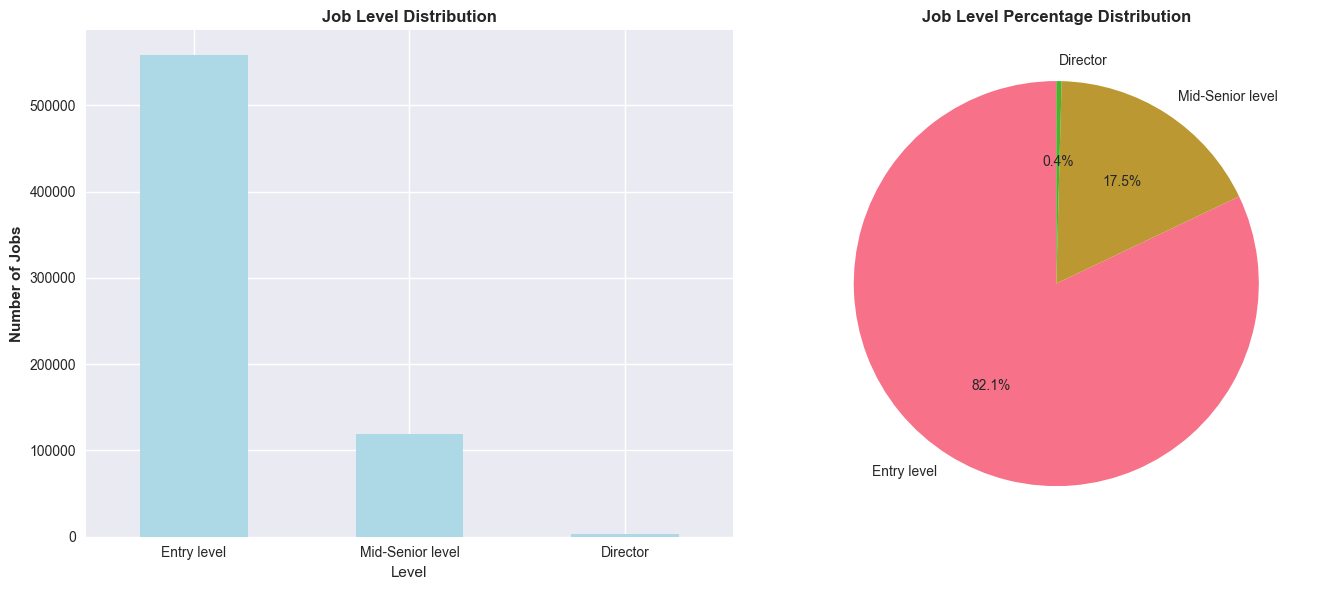

Level
Entry level         559037
Mid-Senior level    119182
Director              2843
Name: count, dtype: int64

In [65]:
def analyze_job_levels(df):
    """Analyze job experience levels"""
    print("\n📊 JOB LEVEL ANALYSIS")
    print("="*60)
    
    level_counts = df['Level'].value_counts()
    
    print("🎯 JOB LEVELS DISTRIBUTION:")
    for level, count in level_counts.items():
        percentage = (count / len(df)) * 100
        print(f"• {level}: {count} jobs ({percentage:.1f}%)")
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Level distribution bar plot
    level_counts.plot(kind='bar', ax=ax1, color='lightblue')
    ax1.set_title('Job Level Distribution', fontweight='bold')
    ax1.set_ylabel('Number of Jobs', fontweight='bold')
    ax1.tick_params(axis='x', rotation=0)
    
    # Level distribution pie chart
    ax2.pie(level_counts.values, labels=level_counts.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Job Level Percentage Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return level_counts

analyze_job_levels(df)


📈 COMPREHENSIVE MARKET DASHBOARD


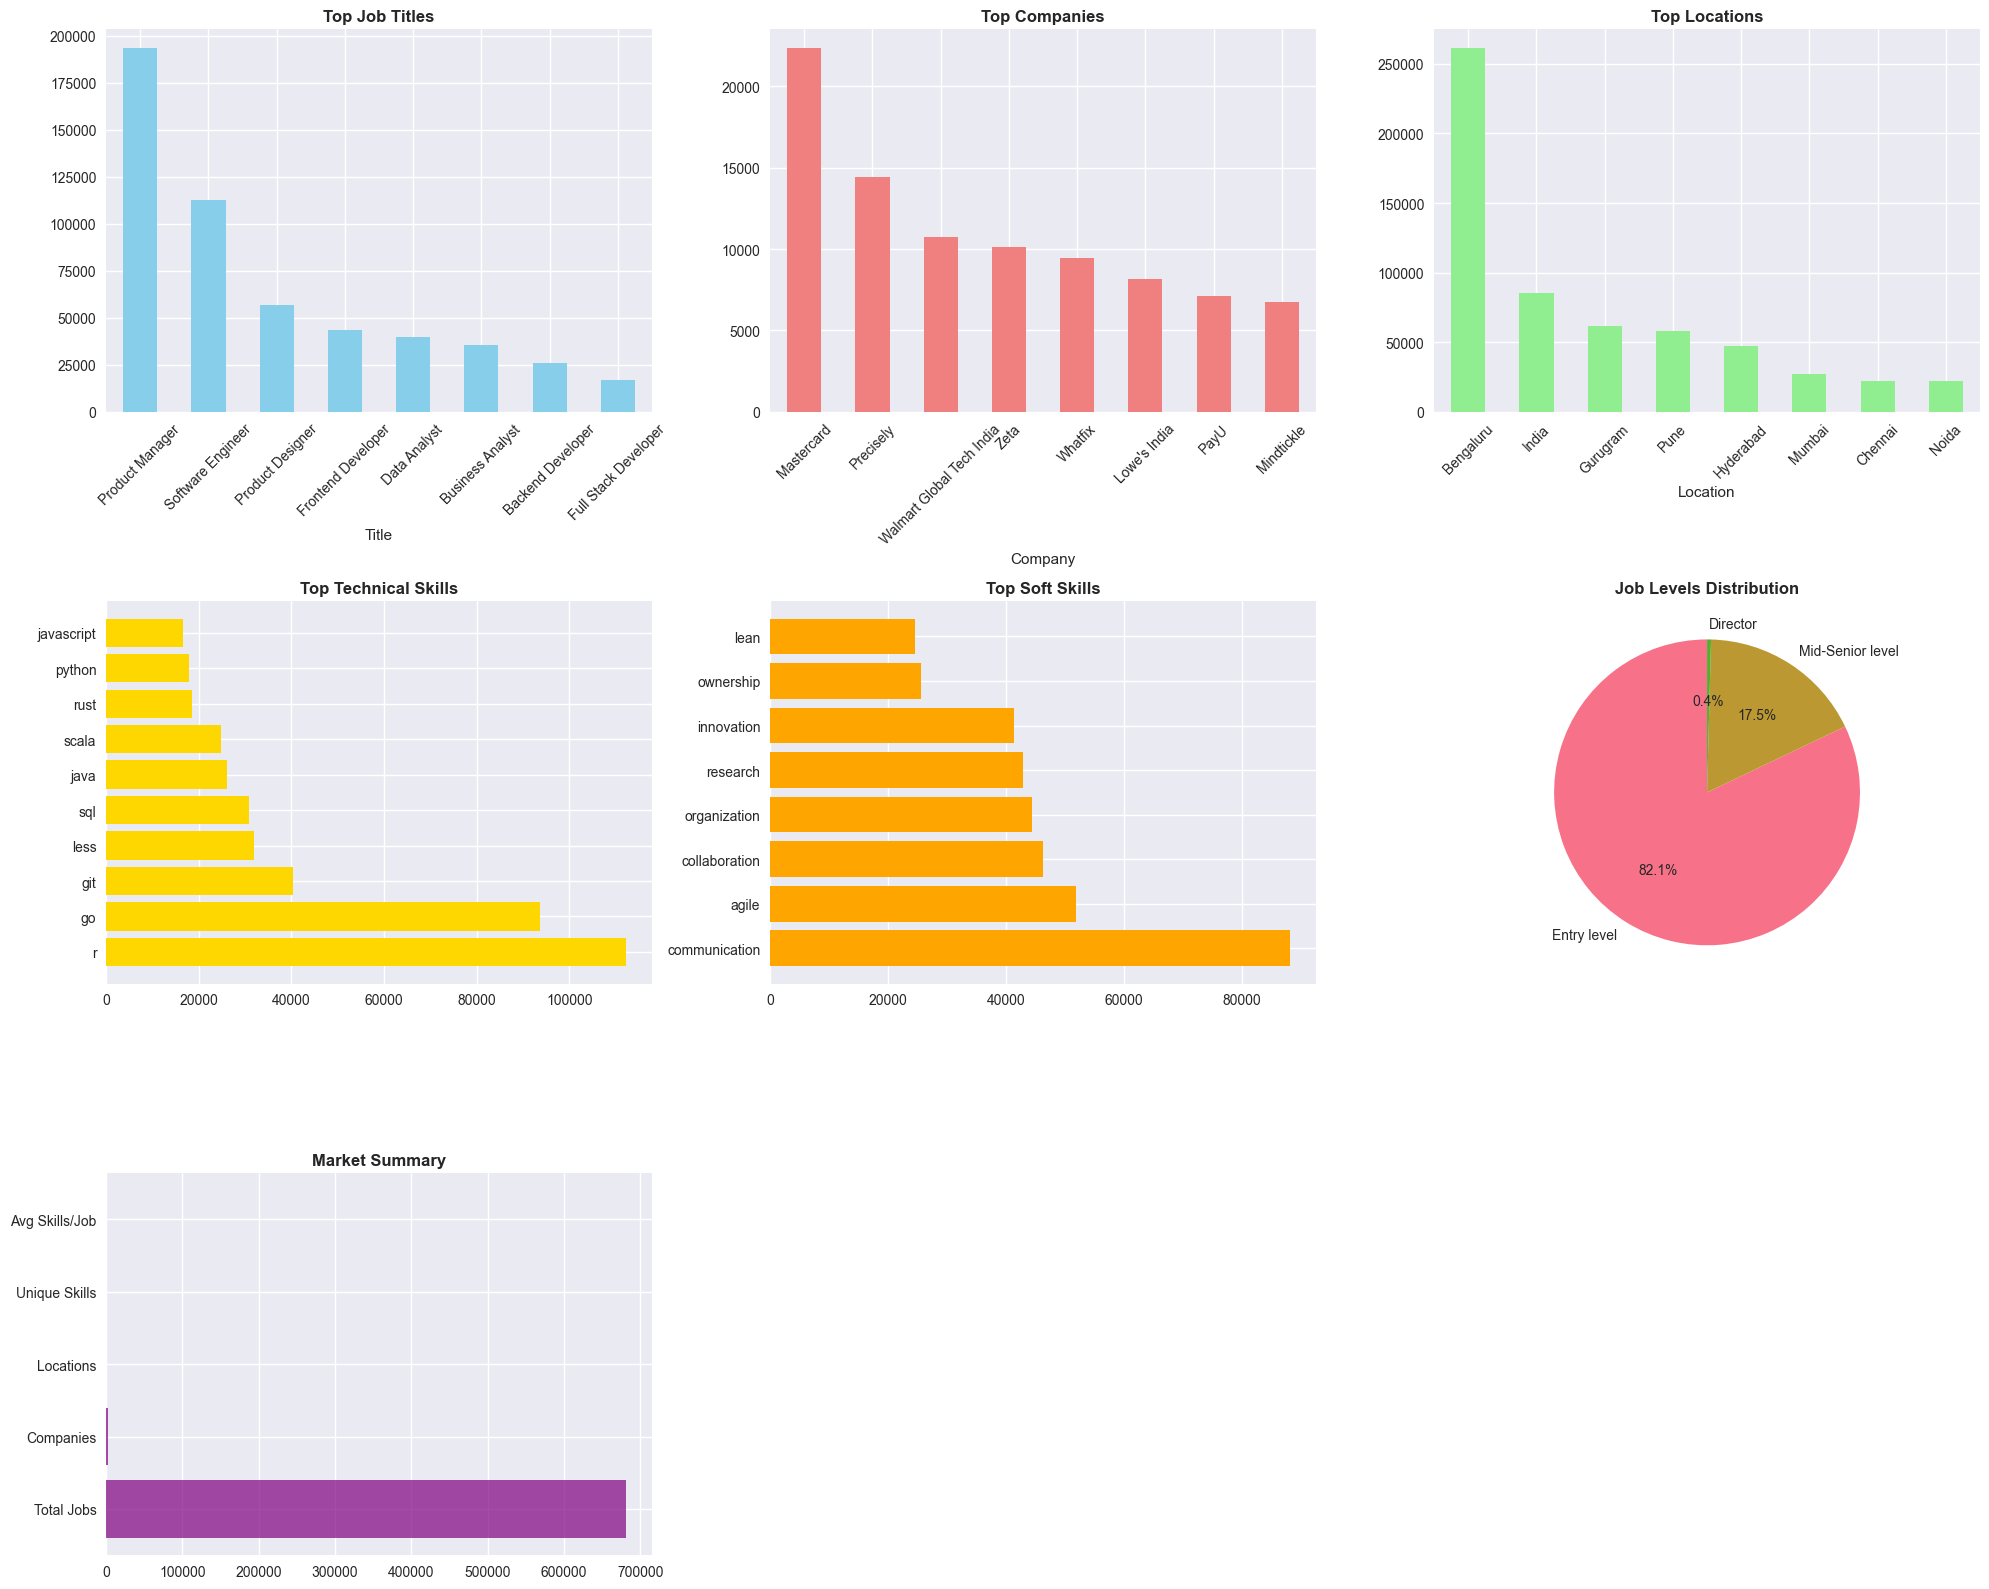

{'Total Jobs': 681062,
 'Companies': 2907,
 'Locations': 138,
 'Unique Skills': 140,
 'Avg Skills/Job': 0.9978856550504946}

In [67]:

def create_comprehensive_dashboard(df):
    """Create a comprehensive analytical dashboard"""
    print("\n📈 COMPREHENSIVE MARKET DASHBOARD")
    print("="*60)
    
    # Create a large dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # Skills analysis
    all_skills = []
    for skills in df['skills'].dropna():
        if pd.notna(skills):
            all_skills.extend([skill.strip().lower() for skill in str(skills).split(',')])
    skills_counter = Counter(all_skills)
    top_skills = dict(Counter(skills_counter).most_common(10))
    
    # Soft skills analysis
    all_soft_skills = []
    for soft_skills in df['soft_skills'].dropna():
        if pd.notna(soft_skills):
            all_soft_skills.extend([skill.strip().lower() for skill in str(soft_skills).split(',')])
    soft_skills_counter = Counter(all_soft_skills)
    top_soft_skills = dict(Counter(soft_skills_counter).most_common(8))
    
    # Create subplots
    ax1 = plt.subplot(3, 3, 1)
    df['Title'].value_counts().head(8).plot(kind='bar', color='skyblue', ax=ax1)
    ax1.set_title('Top Job Titles', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2 = plt.subplot(3, 3, 2)
    df['Company'].value_counts().head(8).plot(kind='bar', color='lightcoral', ax=ax2)
    ax2.set_title('Top Companies', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    ax3 = plt.subplot(3, 3, 3)
    df['Location'].value_counts().head(8).plot(kind='bar', color='lightgreen', ax=ax3)
    ax3.set_title('Top Locations', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    
    ax4 = plt.subplot(3, 3, 4)
    plt.barh(list(top_skills.keys()), list(top_skills.values()), color='gold')
    ax4.set_title('Top Technical Skills', fontweight='bold')
    
    ax5 = plt.subplot(3, 3, 5)
    plt.barh(list(top_soft_skills.keys()), list(top_soft_skills.values()), color='orange')
    ax5.set_title('Top Soft Skills', fontweight='bold')
    
    ax6 = plt.subplot(3, 3, 6)
    df['Level'].value_counts().plot(kind='pie', ax=ax6, autopct='%1.1f%%', startangle=90)
    ax6.set_title('Job Levels Distribution', fontweight='bold')
    ax6.set_ylabel('')
    
    # Summary statistics
    ax7 = plt.subplot(3, 3, 7)
    summary_stats = {
        'Total Jobs': len(df),
        'Companies': df['Company'].nunique(),
        'Locations': df['Location'].nunique(),
        'Unique Skills': len(set(all_skills)),
        'Avg Skills/Job': len(all_skills) / len(df) if len(df) > 0 else 0
    }
    
    y_pos = range(len(summary_stats))
    ax7.barh(y_pos, list(summary_stats.values()), color='purple', alpha=0.7)
    ax7.set_yticks(y_pos)
    ax7.set_yticklabels(list(summary_stats.keys()))
    ax7.set_title('Market Summary', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return summary_stats



create_comprehensive_dashboard(df)